In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from datetime import date
from datetime import time
from sklearn.cluster import KMeans

In [2]:
order_detail_df = pd.read_excel("data/order.xlsx", parse_dates = ['Ngày phát sinh'])
user_df = pd.read_excel("data/user.xlsx")
listening_detail_df = pd.read_excel("data/listening.xlsx")
# usage_df = pd.read_excel("data/Usage.xlsx") 

#### Chuyển kiểu dữ liệu

In [3]:
# Chuyển User_ID và Order_ID, Playlist ID sang category
order_detail_df['Order ID'] = order_detail_df['Order ID'].astype('category')
order_detail_df['ID của user'] = order_detail_df['ID của user'].astype('category')

user_df['User ID'] = user_df['User ID'].astype('category')

listening_detail_df['Playlist ID']=listening_detail_df['Playlist ID'].astype('category')
listening_detail_df['User ID']=listening_detail_df['User ID'].astype('category')

# usage_df['User ID']=usage_df['User ID'].astype('category')


In [4]:
# Chuyển Ngày phát sinh lượt nghe sang kiểu dữ liệu date
listening_detail_df["Ngày phát sinh lượt nghe"] = listening_detail_df["Ngày phát sinh lượt nghe"].map(
                                        lambda x:date(int(x.split("-")[2]),int(x.split("-")[1]),int(x.split("-")[0])))
listening_detail_df["Ngày phát sinh lượt nghe"] = listening_detail_df["Ngày phát sinh lượt nghe"].astype("datetime64")


In [61]:
order_detail_df.head(3)

,Order ID,Ngày phát sinh,ID của user,Loại hoá đơn (9k/Xu/VIP),Giá trị hoá đơn,order_year,order_month,order_day,order_weekday
0,6706,2020-08-16,44822,VIP,199000,2020,08,16,Sunday
1,6998,2020-08-23,47128,VIP,199000,2020,08,23,Sunday
2,6927,2020-08-21,47134,VIP,199000,2020,08,21,Friday


In [7]:
user_df.head(3)

,User ID,VIP hay Free,Giới tính,Năm sinh,Việt Nam hay Nước ngoài,iOS hay Android,Ngày đăng ký tài khoản,Tổng số lượt nghe,Tổng thời lượng nghe (phút)
0,86229,free,male,NaN,VN,android,2020-11-27,218,4151.3
1,48053,free,male,1995.0,VN,ios,2020-08-24,19,278.6
2,46340,free,male,1988.0,VN,website,2020-08-19,28,170.5


In [8]:
listening_detail_df.head(3)

,Playlist ID,Tên playlist,Category tầng 1 của playlist,Category tầng 2 của playlist,Playlist là Free hay VIP,Thời lượng của playlist (phút),Thời lượng của lượt nghe (phút),User ID,Giờ phát sinh lượt nghe,Ngày phát sinh lượt nghe
0,4529,Dạy Tiếng Anh Cho Trẻ Mầm Non,Podcast,Học ngoại ngữ,free,44.9,0.1,82846,06:05,2020-12-03
1,4577,Tư Duy Tích Cực - Bạn Là Những Gì Bạn Nghĩ (Nh...,Sách nói,Hạnh phúc,vip,79.8,15.9,56112,12:49,2020-10-30
2,4169,50 thiên thần của bạn: Giải phóng bản thân khỏ...,Sách nói,Tâm linh,vip,324.8,6.8,94362,00:17,2020-12-15


In [68]:
# listening_detail_df.to_csv("data/pre_listening.csv")

In [9]:
# listening_detail_df.describe(include = 'all')

In [10]:
# order_detail_df.describe(include = 'all')

In [11]:
# user_df.describe(include = 'all')

#### Khảo sát về sự consistence của các USER_ID trong các file

In [151]:
order_userID = order_detail_df['ID của user'].unique()
userID = user_df['User ID'].unique()
listen_userID = listening_detail_df['User ID'].unique()


user_cnt = len(userID)
order_user_cnt = len(order_userID)
listen_user_cnt = len(listen_userID)

order_nolisten_cnt = len([item for item in order_userID if item  not in listen_userID])
listen_noorder_cnt = len([item for item in listen_userID if item  not in order_userID])
order_listen_cnt = len([item for item in listen_userID if item  in order_userID])


user_stat_dict = {"user_cnt":user_cnt,
                "order_user_cnt": order_user_cnt,
                "listen_user_cnt": listen_user_cnt      
                }

order_listen_stat_dict = {"order_listen_cnt":order_listen_cnt,
                "order_nolisten_cnt": order_nolisten_cnt,
                "listen_noorder_cnt": listen_noorder_cnt      
                }

Text(0.5, 1.0, 'The percentage of users in orders')

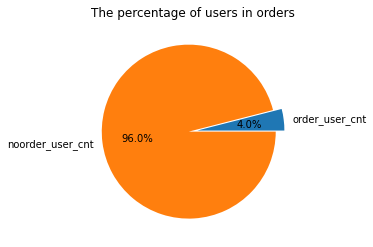

In [152]:
data = [order_user_cnt,user_cnt - order_user_cnt]
label = ["order_user_cnt","noorder_user_cnt"]
plt.pie(x= data , autopct="%.1f%%", explode=[0.05]*len(data),labels=label);
plt.title("The percentage of users in orders")

Text(0.5, 1.0, 'The percentage of users in listening')

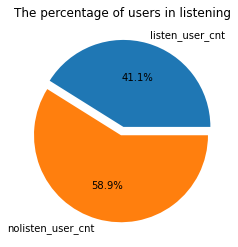

In [153]:
data = [listen_user_cnt,user_cnt - listen_user_cnt]
label = ["listen_user_cnt","nolisten_user_cnt"]
plt.pie(x= data , autopct="%.1f%%", explode=[0.05]*len(data),labels=label);
plt.title("The percentage of users in listening")

Text(0.5, 1.0, 'The percentage of users in orders and listening')

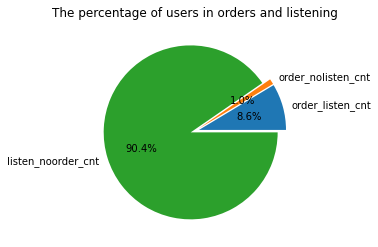

In [154]:
data = order_listen_stat_dict.values()
label = order_listen_stat_dict.keys()
plt.pie(x= data , autopct="%.1f%%", explode=[0.05]*len(data),labels=label);
plt.title("The percentage of users in orders and listening")

##### Xem những người có order mà ko listen hay mua gì

In [155]:
listen_not_in_order_user_df = order_detail_df[~order_detail_df['ID của user'].isin(listening_detail_df['User ID'])]
listen_not_in_order_user_df["Loại hoá đơn (9k/Xu/VIP)"].value_counts()

9K     118
VIP    115
XU      97
Name: Loại hoá đơn (9k/Xu/VIP), dtype: int64

## Xét ORDERs

In [156]:
order_detail_df.head(3)

,Order ID,Ngày phát sinh,ID của user,Loại hoá đơn (9k/Xu/VIP),Giá trị hoá đơn
0,6706,2020-08-16,44822,VIP,199000
1,6998,2020-08-23,47128,VIP,199000
2,6927,2020-08-21,47134,VIP,199000


In [5]:
##### Cắt nhỏ giá trị order_date

order_detail_df['order_year'] = order_detail_df['Ngày phát sinh'].map(lambda x: x.strftime('%Y'))
order_detail_df['order_month'] = order_detail_df['Ngày phát sinh'].map(lambda x: x.strftime('%m'))
order_detail_df['order_day'] = order_detail_df['Ngày phát sinh'].map(lambda x: x.strftime('%d'))
order_detail_df['order_weekday'] = order_detail_df['Ngày phát sinh'].map(lambda x: x.strftime('%A'))
order_detail_df.head(3)

,Order ID,Ngày phát sinh,ID của user,Loại hoá đơn (9k/Xu/VIP),Giá trị hoá đơn,order_year,order_month,order_day,order_weekday
0,6706,2020-08-16,44822,VIP,199000,2020,08,16,Sunday
1,6998,2020-08-23,47128,VIP,199000,2020,08,23,Sunday
2,6927,2020-08-21,47134,VIP,199000,2020,08,21,Friday


## Xét Listenings

In [158]:
listening_detail_df.head(3)

,Playlist ID,Tên playlist,Category tầng 1 của playlist,Category tầng 2 của playlist,Playlist là Free hay VIP,Thời lượng của playlist (phút),Thời lượng của lượt nghe (phút),User ID,Giờ phát sinh lượt nghe,Ngày phát sinh lượt nghe
0,4529,Dạy Tiếng Anh Cho Trẻ Mầm Non,Podcast,Học ngoại ngữ,free,44.9,0.1,82846,06:05,2020-12-03
1,4577,Tư Duy Tích Cực - Bạn Là Những Gì Bạn Nghĩ (Nh...,Sách nói,Hạnh phúc,vip,79.8,15.9,56112,12:49,2020-10-30
2,4169,50 thiên thần của bạn: Giải phóng bản thân khỏ...,Sách nói,Tâm linh,vip,324.8,6.8,94362,00:17,2020-12-15


## Summary Listenings and Orders

In [ ]:
## Tạo order_summary_df và listening_summary_df để chứa dữ liệu thống kê về orders và listenings
## Tạo user_cluster_df để chứa dữ liệu về user_cluster

In [5]:
order_summary_df = order_detail_df.groupby('ID của user').agg(
                    {'Ngày phát sinh': ['min', 'max', 'count'],
                     'Giá trị hoá đơn': 'sum',
                    }
                    ).reset_index()
order_summary_df.columns = ['User_ID','min_purchase_date','max_purchase_date','order_cnt','revenue']

order_summary_df.head(3)

,User_ID,min_purchase_date,max_purchase_date,order_cnt,revenue
0,40843,2020-09-15,2020-10-21,3,27000
1,40861,2020-09-09,2020-09-09,1,199000
2,41003,2020-10-27,2020-10-27,1,599000


In [6]:
listening_summary_df = listening_detail_df.groupby('User ID').agg(
                    {"Ngày phát sinh lượt nghe":['min','max'],
                     "Thời lượng của lượt nghe (phút)":["mean","std",'count','sum']
                    }
                ).reset_index()
listening_summary_df.columns = ['User_ID','first_listen_date','last_listen_date','avg_duration_per_listen','std_avg_duration_per_listen','listen_cnt','total_listen_minute']
listening_summary_df.head(3)

,User_ID,first_listen_date,last_listen_date,avg_duration_per_listen,std_avg_duration_per_listen,listen_cnt,total_listen_minute
0,40834,2020-07-08,2020-07-08,4.350000,6.010408,2,8.7
1,40835,2020-09-02,2020-10-07,13.760000,11.251578,5,68.8
2,40839,2020-07-21,2020-10-11,18.408333,12.992909,60,1104.5


In [7]:
# Lấy user_id từ 2 bảng order_summary_df và listening_summary_df gộp vào 1 bảng
user_cluster_df= pd.DataFrame(pd.concat(objs=[listening_summary_df['User_ID'],order_summary_df['User_ID']]).drop_duplicates().reset_index(drop=True))
user_cluster_df.columns = ["User_ID"]
user_cluster_df.shape[0]

27458

### Nhận xét về dữ liệu:

In [162]:
da = listening_summary_df.join(order_summary_df[["User_ID","revenue"]].set_index("User_ID"),on="User_ID",how="outer")
da.loc[da["revenue"] <= 0.0].shape[0]

0

In [163]:
t = da.loc[da['revenue'].isnull()]
t[t['total_listen_minute'] == 0.0].shape[0]

93

#### Summary:
1. Ta chỉ xét những user đã có giao dịch hoặc những user đã sử dụng app (đã nghe sách): khoảng 27k users
2. Trong đó, có:
    * Những users đã thực hiện giao dịch đều có tổng giá trị giao dịch > 0.0
    * 1% số lượng PAY users đã giao dịch(order) nhưng chưa nghe (nolisten) (chưa bấm nút nghe của bất kì playlist nào): 275 users
    * 8.6% PAY users đã giao dịch và đã nghe (2363 users)
    * Còn lại 90.4% FREE users đã nghe và CHƯA giao dịch (24820 users), trong đó có 93  free user có tổng thời gian nghe là 0.0 phút -chưa trải nghiệm playlist nào ()

# CLUSTERING

In [8]:
# for Ebowl
def find_sse(df, max_k):
    sse = {}
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k, max_iter=1000)
        kmeans.fit(df)
        df['clusters'] = kmeans.labels_
        sse[k] = kmeans.inertia_
    return sse
   
## function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

## Calculate metrics

### Nối các thông tin chung của user lại

In [9]:
# user_cluster_df = user_cluster_df.join(order_summary_df.set_index("User_ID"),on="User_ID",how="outer")
user_cluster_df = user_cluster_df.join(listening_summary_df.set_index("User_ID"),on="User_ID",how="outer")

In [10]:
user_cluster_df = user_cluster_df.join(order_summary_df.set_index("User_ID"),on="User_ID",how="outer")

In [11]:
user_cluster_df = user_cluster_df.join(user_df[["User ID","Ngày đăng ký tài khoản"]].set_index("User ID"),
                                       on="User_ID",how="inner")

In [12]:
user_cluster_df = user_cluster_df.rename(columns = {'Ngày đăng ký tài khoản':'signup_date'})

In [13]:
user_cluster_df["type_user"] = user_cluster_df['revenue'].isnull().map(lambda x: "free" if x else 'subcribe')
user_cluster_df["type_user"].value_counts()

free        24820
subcribe     2638
Name: type_user, dtype: int64

### 1. Density: avg_duration_per_listen: thời lượng trung bình của 1 lượt nghe (theo đơn vị phút)

In [14]:
## Density: thời lượng tb của 1 lượt nghe: Nếu user chưa nghe thì có Density = 0

# 'Density' = 'avg_duration_per_listen' nếu 'avg_duration_per_listen' != NaN, ngược lại thì bằng 0.0
# user_cluster_df['Density'] = user_cluster_df['avg_duration_per_listen'].fillna(value = 0.0)
user_cluster_df['Density'] = user_cluster_df['avg_duration_per_listen']
user_cluster_df['Density'].isnull().sum()

275

### 2.Recency: the distance (in days) between the lastest active day of a user and the max  the active day in data set

In [15]:
user_cluster_df['last_active_date'] = user_cluster_df[["max_purchase_date","last_listen_date","signup_date"]].max(axis = 1)

In [47]:
## Recency: khoảng cách giữa lần nghe gần nhất của mỗi user đến max_listen_date trên toàn bộ tập dữ liệu
# the lastest active day = max(the_max_purchase_date, the_last_listen_date,Ngày đăng ký tài khoản)
## Recency càng nhỏ thì càng tốt

maxActiveDay = max(user_cluster_df["max_purchase_date"].max(),user_cluster_df["last_listen_date"].max(),
                      user_cluster_df["signup_date"].max())

user_cluster_df['last_active_date'] = user_cluster_df[["max_purchase_date","last_listen_date","signup_date"]].max(axis = 1)

user_cluster_df['Recency']=(maxActiveDay - user_cluster_df['last_active_date']).dt.days

user_cluster_df['Recency'].isnull().sum()

# users with 0_Recency are the most active ones

0

### 3. Frequency: avg_listen_cnt_per_week: số lượt nghe tb trong 1 ngày nghe

In [112]:
#1 Tính số tuần đã trôi qua trên hệ quy chiếu thời gian của bản thân user
user_cluster_df['listen_week_cnt'] = user_cluster_df.apply(
                                lambda x: 1 if x['last_listen_date'] == x["first_listen_date"] 
                                            else round(((x['last_listen_date']-x["first_listen_date"]).days+1)/7 + 0.4,0), axis=1)

user_cluster_df['Frequency_listenweek'] = user_cluster_df['listen_cnt']/user_cluster_df['listen_week_cnt']
user_cluster_df['Frequency_listenweek'] = user_cluster_df['Frequency_listenweek'].fillna(value = float(0.0))

# #2. Tính số tuần đã trôi qua trên hệ quy chiếu thời gian có cận trên là maxListenDate cho toàn bộ tập dữ liệu
# # cận dưới là ngày nghe lần đầu của mỗi user
# maxListenDate = user_cluster_df['last_listen_date'].max()
# user_cluster_df['bias_listen_week_cnt'] = user_cluster_df["first_listen_date"].map(
#                                 lambda x: 1 if maxListenDate == x
#                                             else round(( maxListenDate-x).days/7 + 0.4,0))

In [113]:
#2 Tính số ngày đã trôi qua trên hệ quy chiếu thời gian của bản thân user
user_cluster_df['listen_day_cnt'] = user_cluster_df.apply(
                                lambda x: 1 if x['last_listen_date'] == x["first_listen_date"] 
                                            else ( x['last_listen_date']-x["first_listen_date"]).days+1, axis=1)

user_cluster_df['Frequency_listenday'] = user_cluster_df['listen_cnt']/user_cluster_df['listen_day_cnt']
user_cluster_df['Frequency_listenday'] = user_cluster_df['Frequency_listenday'].fillna(value = float(0.0))

In [18]:
user_cluster_df['Frequency_listenday'].isnull().sum()

0

### 5. Monetary

#### 5.1. Monetary_lifeweek: avg_spending_per_week: số tiền bỏ ra / 1 life week

In [110]:
# Monetary: avg_spending_per_week: số tiền bỏ ra / 1 week
# Ta lấy revenue của mỗi user chia cho life_week_cnt của user đó
# Nếu revenue của user là NaN: Monetary = 0.0
# Nếu revenue != 0 mà listening

# Timeline của user: từ lúc signup đến lúc the_last_active_date:
user_cluster_df['life_week_cnt']= user_cluster_df.apply(
                                lambda x: 1 if x['last_active_date'] == x["signup_date"] 
                                            else round(((x['last_active_date']-x["signup_date"]).days+1)/7 + 0.4,0), axis=1)

user_cluster_df['Monetary_lifeweek'] = user_cluster_df['revenue']
user_cluster_df['Monetary_lifeweek'] = user_cluster_df['Monetary_lifeweek'] / user_cluster_df['life_week_cnt']

#### 5.2.Monetary_orderweek: avg_spending_per_week: số tiền bỏ ra / 1 order week

In [111]:
# Monetary: avg_spending_per_week: số tiền bỏ ra / 1 week
# Ta lấy revenue của mỗi user chia cho order_week_cnt của user đó
# Nếu revenue của user là NaN: Monetary = 0.0
# Nếu revenue != 0 mà listening

# Timeline của user: từ lúc the min_purcharse_date đến lúc max_purcharse_date:
user_cluster_df['order_week_cnt']= user_cluster_df.apply(
                                lambda x: 1 if x["max_purchase_date"] == x["min_purchase_date"] 
                                            else round(((x["max_purchase_date"]-x["min_purchase_date"]).days+1)/7 + 0.4,0), axis=1)

user_cluster_df['Monetary_orderweek'] = user_cluster_df['revenue']
user_cluster_df['Monetary_orderweek'] = user_cluster_df['Monetary_orderweek'] / user_cluster_df['order_week_cnt']

#### 5.3.Monetary_orderday: avg_spending_per_day: số tiền bỏ ra / 1 order day

In [84]:
user_cluster_df['order_day_cnt']= user_cluster_df.apply(
                                lambda x: 1 if x["max_purchase_date"] == x["min_purchase_date"] 
                                            else (x["max_purchase_date"]-x["min_purchase_date"]).days+1, axis=1)


In [85]:
user_cluster_df['Monetary_orderday'] = user_cluster_df['revenue']
user_cluster_df['Monetary_orderday'] = user_cluster_df['Monetary_orderday'] / user_cluster_df['order_day_cnt']

#### 5.4. Monetary: avg_spending_per_listen: số tiền bỏ ra / 1 listen

In [54]:
# Những người đã order nhưng chưa kịp nghe: cho tổng số lần nghe là 1
user_cluster_df['Monetary_per_listen'] = user_cluster_df['revenue']/user_cluster_df['listen_cnt'].fillna(1)

In [55]:
user_cluster_df['Monetary_per_listen'].isnull().sum()

24820

In [48]:
# user_cluster_df.to_csv("data/user_cluster_df.csv")

### Summary
1. Có 2 cluster cho 2 nhóm user:
    * Nhóm Free users (type_user = 'free'): RFD
    * Nhóm Subcribe users (type_user = 'subcribe'): RFM
2. Giải thích các metrics:
    * R Recency: khoảng cách tính bằng ngày từ lần active cuối cùng của user đến ngày max(active cuối cùng)
        R càng nhỏ có nghĩa sự recency càng cao --> càng tốt
    * F Frequency: số lượt nghe của mỗi user trong mỗi tuần (listen_cnt/listen_week_cnt)
        F càng cao thì mức độ activeness càng lớn --> càng tốt
        Nếu user chưa nghe lần nào thì Frequency = 0
    * M Monetary: trung bình chi phí cho mỗi lượt nghe (revenue/listen_cnt)
        M càng cao thì càng tốt về mặc lợi nhuận
    * D Density: thời lượng trung bình trong mỗi lượt nghe (total_listen_time / listen_cnt)
        D càng cao --> user càng enjoy app

## NORMALIZE Density - Recency - Frequency - Monetary

In [43]:
user_cluster_df["type_user"].value_counts()

free        24820
subcribe     2638
Name: type_user, dtype: int64

# CLUSTERING

## 1.Subcribers: RFM CLUSTERING (recency - frequency - monetary)

1. frequency: số lần nghe trong 1 ngày
2. monetary: số tiền trả trong 1 ngày

In [88]:
user_cluster_df.columns

Index(['User_ID', 'first_listen_date', 'last_listen_date',
       'avg_duration_per_listen', 'std_avg_duration_per_listen', 'listen_cnt',
       'total_listen_minute', 'min_purchase_date', 'max_purchase_date',
       'order_cnt', 'revenue', 'signup_date', 'type_user', 'Density',
       'last_active_date', 'listen_week_cnt', 'Frequency_listenweek',
       'listen_day_cnt', 'Frequency_listenday', 'life_week_cnt',
       'Monetary_lifeweek', 'order_week_cnt', 'Monetary_orderweek',
       'order_day_cnt', 'Monetary_orderday', 'Monetary_per_listen', 'Recency'],
      dtype='object')

In [89]:
# subcribe_cluster_df chứa dữ liệu subcriber segment
cols= ["User_ID",'type_user','Recency','Frequency_listenday','Monetary_orderday']
subcribe_cluster_df = user_cluster_df.loc[user_cluster_df['type_user']=='subcribe',cols]
subcribe_cluster_df = subcribe_cluster_df.rename(columns={"Monetary_orderday": "Monetary","Frequency_listenday":"Frequency"})

In [144]:
# free_cluster_df chứa dữ liệu free user segment
cols= ["User_ID",'type_user','Recency','Frequency_listenday','Density']
free_cluster_df = user_cluster_df[user_cluster_df['type_user']=='free'][cols]
free_cluster_df = free_cluster_df.rename(columns={"Frequency_listenday":"Frequency"})

In [91]:
subcribe_cluster_df.shape[0],free_cluster_df.shape[0]

(2638, 24820)

### 1. Normalize: MinMaxScale

In [256]:
# from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [92]:
def min_max_scale(df,scale_cols):
    for col in scale_cols:
        min_val = df[col].min()
        max_val = df[col].max()
        distance = max_val - min_val
        df['scaled'+str(col)] = (df[col]-min_val)/distance
    return df

def run_kmean_clustering(df,cluster_cols,k_cluster,k_iter = 1000):
    kmeans = KMeans(n_clusters=k_cluster, max_iter = k_iter )
    kmeans.fit(df[cluster_cols])
    prefix = cluster_cols[0]
    df[str(prefix)+"Cluster"]= kmeans.predict((df[cluster_cols]))
    return df

In [93]:
subcribe_cluster_df.describe()

,Recency,Frequency,Monetary
count,2638.000000,2638.000000,2638.000000
mean,27.904473,2.711218,211895.714952
std,35.420439,3.411417,211175.580428
min,0.000000,0.000000,151.260504
25%,2.000000,0.708882,9000.000000
50%,11.000000,1.735088,199000.000000
75%,41.000000,3.447108,244000.000000
max,168.000000,43.000000,1000000.000000


In [60]:
# subcribe_cluster_df = min_max_scale(subcribe_cluster_df,["Recency","Frequency","Monetary"])
# subcribe_cluster_df[["scaledRecency","scaledFrequency","scaledMonetary"]].describe()

### Recency

#### 1. Plot R

In [61]:
subcribe_cluster_df['Recency'].describe()

count    2638.000000
mean       27.904473
std        35.420439
min         0.000000
25%         2.000000
50%        11.000000
75%        41.000000
max       168.000000
Name: Recency, dtype: float64

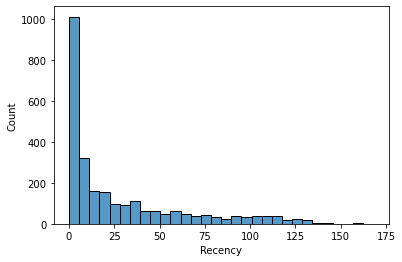

In [63]:
sns.histplot(data=subcribe_cluster_df,x='Recency');

#### 2. Determine K for Recency

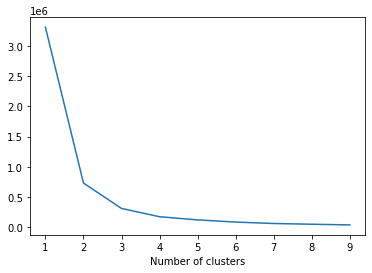

In [64]:
## Elbow Method to determine K
sse = find_sse(subcribe_cluster_df.loc[:,['Recency']], max_k = 10) 

plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel("Number of clusters")
plt.show() 

# # Optimal R_K=3
# ## Choose the k of Recency_clusters = 3
# ## 1st: 'active', 2st: 'sleep', 3rd: 'hibernate'

#### 3. Recency Clustering

In [94]:
# ## RecencyCluster_k = 3
k_clus = 3
subcribe_cluster_df = run_kmean_clustering(subcribe_cluster_df,["Recency"],k_cluster=k_clus)

## Sắp theo thứ tự R càng thấp thì Cluster càng cao
subcribe_cluster_df = order_cluster('RecencyCluster', 'Recency',subcribe_cluster_df,False)
subcribe_cluster_df.groupby("RecencyCluster")['Recency'].describe()

# ## see details of each cluster - Recency

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,355.0,103.484507,18.468837,75.0,88.5,104.0,116.0,168.0
1,549.0,46.256831,13.535624,27.0,35.0,43.0,57.0,74.0
2,1734.0,6.620531,7.164231,0.0,1.0,4.0,11.0,26.0


#### 4.Summary: Recency chia làm 3 nhóm:
1. Nhóm 0: 'hibernate': lần cuối cùng cách > 3 tháng
2. Nhóm 1: 'sleep': lần cuối cùng cách 1.5 tháng (từ 1 - 2 tháng)chưa dùng app
3. Nhóm 2: 'active': có dùng app trong khoảng 1 tuần (trong vòng nửa tháng)


### Frequency - số lần nghe trong 1 ngày

#### 1. Plot F

In [76]:
subcribe_cluster_df["Frequency"].describe()

count    2638.000000
mean        3.019317
std         4.141072
min         0.000000
25%         0.728039
50%         1.832364
75%         3.797917
max        61.000000
Name: Frequency, dtype: float64

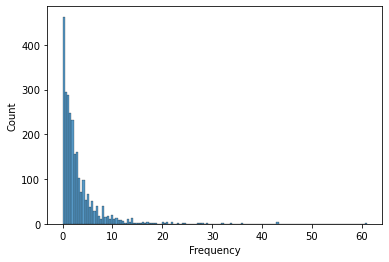

In [78]:
sns.histplot(data=subcribe_cluster_df,x='Frequency');

#### 2. Determine K for Frequency

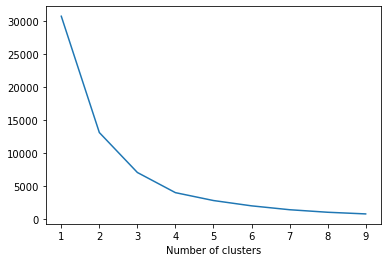

In [95]:
## Elbow Method to determine K

sse = find_sse(subcribe_cluster_df.loc[:,['Frequency']], max_k = 10) 

plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel("Number of clusters")
plt.show() 

# k_optimal  = 4

#### 3. Frequency Clustering

In [96]:
# ## RecencyCluster_k = 4
k_clus = 4
subcribe_cluster_df = run_kmean_clustering(subcribe_cluster_df,["Frequency"],k_cluster=k_clus)

## Sắp theo thứ tự R càng thấp thì Cluster càng cao
subcribe_cluster_df = order_cluster('FrequencyCluster', 'Frequency',subcribe_cluster_df,True)
subcribe_cluster_df.groupby("FrequencyCluster")['Frequency'].describe()

# ## see details of each cluster - Frequency

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1710.0,1.035637,0.763221,0.000000,0.375000,1.000000,1.666667,2.545455
1,692.0,4.053987,1.109656,2.555556,3.037775,3.885704,4.974138,6.750000
2,215.0,9.495326,2.336355,6.800000,7.879032,8.750000,11.000000,17.000000
3,21.0,25.447619,6.613064,18.000000,20.000000,22.000000,29.000000,43.000000


In [103]:
user_cluster_df.columns

Index(['User_ID', 'first_listen_date', 'last_listen_date',
       'avg_duration_per_listen', 'std_avg_duration_per_listen', 'listen_cnt',
       'total_listen_minute', 'min_purchase_date', 'max_purchase_date',
       'order_cnt', 'revenue', 'signup_date', 'type_user', 'Density',
       'last_active_date', 'listen_week_cnt', 'Frequency_listenweek',
       'listen_day_cnt', 'Frequency_listenday', 'life_week_cnt',
       'Monetary_lifeweek', 'order_week_cnt', 'Monetary_orderweek',
       'order_day_cnt', 'Monetary_orderday', 'Monetary_per_listen', 'Recency'],
      dtype='object')

In [108]:
user_cluster_df[(user_cluster_df.Frequency_listenday >= 18.0) & (user_cluster_df.type_user == 'subcribe')]

,User_ID,first_listen_date,last_listen_date,avg_duration_per_listen,std_avg_duration_per_listen,listen_cnt,total_listen_minute,min_purchase_date,max_purchase_date,order_cnt,...,listen_day_cnt,Frequency_listenday,life_week_cnt,Monetary_lifeweek,order_week_cnt,Monetary_orderweek,order_day_cnt,Monetary_orderday,Monetary_per_listen,Recency
6505,57378,2020-11-10,2020-11-10,15.661905,7.547481,21.0,328.9,2020-10-01,2020-10-01,1.0,...,1.0,21.0,7.0,85571.428571,1.0,599000.0,1.0,599000.000000,28523.809524,51
7624,61044,2020-12-29,2020-12-30,31.300000,21.578495,36.0,1126.8,2020-12-26,2020-12-26,1.0,...,2.0,18.0,13.0,32307.692308,1.0,420000.0,1.0,420000.000000,11666.666667,1
12972,73416,2020-11-03,2020-11-04,2.490698,8.506771,43.0,107.1,2020-11-03,2020-11-03,1.0,...,2.0,21.5,1.0,9000.000000,1.0,9000.0,1.0,9000.000000,209.302326,57
14628,76980,2020-11-10,2020-11-10,0.581818,0.978160,22.0,12.8,2020-11-10,2020-11-10,1.0,...,1.0,22.0,1.0,199000.000000,1.0,199000.0,1.0,199000.000000,9045.454545,51
15449,78868,2020-11-29,2020-11-29,13.850000,11.493112,32.0,443.2,2020-11-21,2020-11-21,1.0,...,1.0,32.0,3.0,66333.333333,1.0,199000.0,1.0,199000.000000,6218.750000,32
17291,82953,2020-11-21,2020-11-25,11.223256,36.252305,172.0,1930.4,2020-11-21,2020-11-21,1.0,...,5.0,34.4,1.0,9000.000000,1.0,9000.0,1.0,9000.000000,52.325581,36
17716,83850,2020-12-02,2020-12-02,13.048148,9.704613,27.0,352.3,2020-11-24,2020-11-24,1.0,...,1.0,27.0,2.0,79500.000000,1.0,159000.0,1.0,159000.000000,5888.888889,29
17834,84148,2020-12-14,2020-12-14,24.711111,21.783720,18.0,444.8,2020-11-25,2020-11-25,1.0,...,1.0,18.0,4.0,39750.000000,1.0,159000.0,1.0,159000.000000,8833.333333,17
18599,85851,2020-12-15,2020-12-15,11.988235,7.650382,34.0,407.6,2020-12-15,2020-12-15,1.0,...,1.0,34.0,3.0,66333.333333,1.0,199000.0,1.0,199000.000000,5852.941176,16
18997,86736,2020-12-29,2020-12-29,35.637500,13.296479,24.0,855.3,2020-09-21,2020-11-28,2.0,...,1.0,24.0,5.0,18000.000000,10.0,9000.0,69.0,1304.347826,3750.000000,2


In [ ]:
# Gộp nhóm 2+3

#### 4.Summary: Frequency chia làm 4 nhóm:
1. Nhóm 0: ít dùng : mỗi ngày khoảng 0-2 lần
2. Nhóm 1: dùng tương đối: mỗi ngày khoảng 5-7 lần
3. Nhóm 2: Hay dùng: mỗi ngày khoảng 10-15 lần
4. Nhóm 3: Rất hay dùng: mỗi ngày khoảng >20 lần

### Monetary - số tiền cho 1  order_day

#### 1. Plot M

In [114]:
subcribe_cluster_df["Monetary"].describe()

count       2638.000000
mean      211895.714952
std       211175.580428
min          151.260504
25%         9000.000000
50%       199000.000000
75%       244000.000000
max      1000000.000000
Name: Monetary, dtype: float64

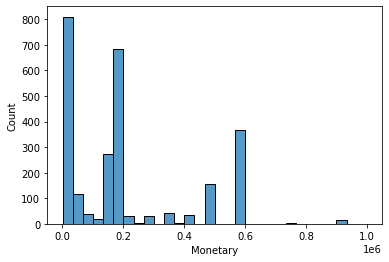

In [115]:
sns.histplot(data=subcribe_cluster_df,x='Monetary');

#### 2. Determine K for Monerary

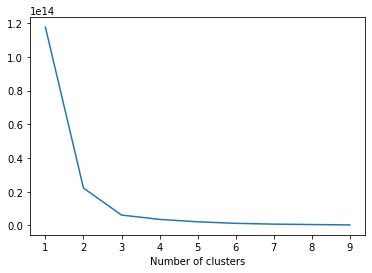

In [116]:
## Elbow Method to determine K

sse = find_sse(subcribe_cluster_df.loc[:,['Monetary']], max_k = 10) 

plt.figure()
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel("Number of clusters")
plt.show() 

# k_optimal  = 3

#### 3. Monerary Clustering

In [119]:
# ## MonetaryCluster_k = 3
k_clus = 4
subcribe_cluster_df = run_kmean_clustering(subcribe_cluster_df,["Monetary"],k_cluster=k_clus)

## Sắp theo thứ tự R càng thấp thì Cluster càng cao
subcribe_cluster_df = order_cluster('MonetaryCluster', 'Monetary',subcribe_cluster_df,True)
subcribe_cluster_df.groupby("MonetaryCluster")['Monetary'].describe()

# ## see details of each cluster - Money

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,965.0,15740.257060,18898.345014,151.260504,4692.307692,9000.0,11461.538462,99000.0
1,1046.0,188702.722734,27943.433284,104000.000000,159000.000000,199000.0,199000.000000,314500.0
2,241.0,456707.468880,61269.031960,345000.000000,420000.000000,499000.0,499000.000000,499000.0
3,386.0,612284.974093,62816.050824,559000.000000,599000.000000,599000.0,599000.000000,1000000.0


#### 4.Summary: Monetary chia làm 3 nhóm:
1. Nhóm 0: Giá trị thấp: trung bình trả 23k cho mỗi tuần theo order (0->50k)chủ yếu mua gói 9k đề dùng thử 
2. Nhóm 1: Giá trị TB: trung bình trả 190k cho mỗi tuần theo order (120k - 390k)
3. Nhóm 2: Giá trị cao: trung bình trả gần 600k cho mỗi tuần theo order
4. Nhóm 3: Giá trị rất cao: trung bình trả gần 1tr cho mỗi tuần theo order

### OverallCluster:
1. R: 3
2. F: 4
3. M: 4 (0,1, 2+3)

In [109]:
subcribe_cluster_df["ClusterCode"] = subcribe_cluster_df["RecencyCluster"].astype("string")+subcribe_cluster_df["FrequencyCluster"].astype("string")+subcribe_cluster_df["MonetaryCluster"].astype("string")

In [112]:
subcribe_cluster_df["ClusterCode"].value_counts()

201    517
200    343
202    293
211    218
101    201
100    164
000    146
212    131
210    114
001     91
102     76
221     57
002     37
010     33
111     33
110     32
222     22
011     21
220     17
203     11
021     11
121     11
112      9
122      6
020      6
231      6
012      5
120      5
103      4
003      3
130      3
131      3
232      3
022      2
213      1
132      1
230      1
123      1
Name: ClusterCode, dtype: Int64

## 2.Free users: RFD CLUSTERING (recency - frequency - Denstity)

In [ ]:
free_cluster_df1 = free_cluster_df.copy()

### Xử lý outlier
1. vì free user nên sẽ có 1 số điểm dữ liệu ko phản ánh đúng behavior của người dùng (có thể là các tester dùng để test sản phẩm)

In [219]:
def visualize_numerical(df, column, target = None):

    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 4));

    sns.histplot(df[column], ax=ax1, kde=True);
    ax1.set_xlabel(column);
    ax1.set_ylabel('Number');
    ax1.set_title(f'{column}  Distribution');
    
    if(target == None):
        sns.boxplot(y=column, data=df, showmeans=True, ax=ax2);
        ax2.set_ylabel(column);
    else:
        sns.boxplot(x=target, y=column, data=df, showmeans=True, ax=ax2);
        ax2.set_xlabel('Target');
        ax2.set_ylabel(column);
    
    plt.show()

def visualize_numerical_lst(df, numerical = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',\
                            'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], target = None):
    for column in numerical:
        visualize_numerical(df,column, target)
        print();

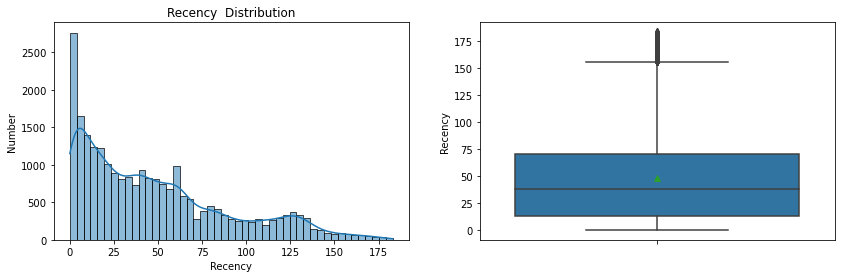

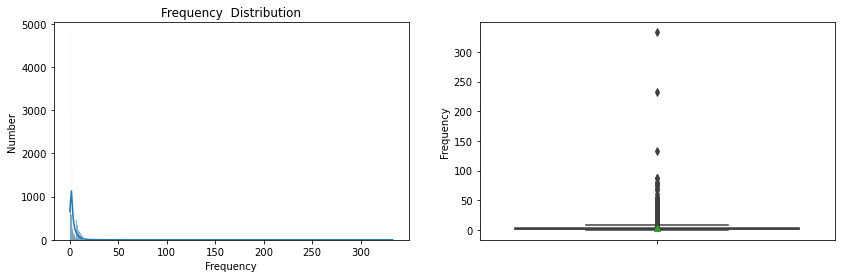

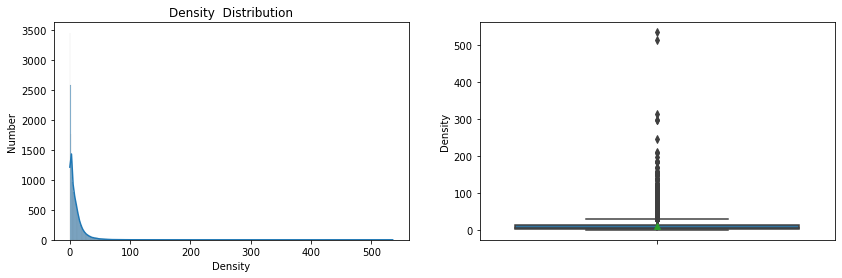

In [220]:
visualize_numerical_lst(free_cluster_df,["Recency","Frequency","Density"])

In [230]:
# free_cluster_df = free_cluster_df1

In [221]:
# ### Cắt bỏ các user có độ frequency thất thường >80 lần 1 ngày
# free_cluster_df = free_cluster_df[free_cluster_df["Frequency"] < 80][]
# free_cluster_df.shape[0]

In [231]:
### Thay thế Density của các trường hợp >quantile95 bằng chính nó
q95 = free_cluster_df["Frequency"].quantile(0.995)
free_cluster_df["Frequency"]=free_cluster_df["Frequency"].map(lambda x: q95 if x>q95 else x)

### Thay thế Density của các trường hợp >quantile95 bằng chính nó
q95 = free_cluster_df["Density"].quantile(0.995)
free_cluster_df["Density"]=free_cluster_df["Density"].map(lambda x: q95 if x>q95 else x)

#### Plot Recency, Frequency, Density

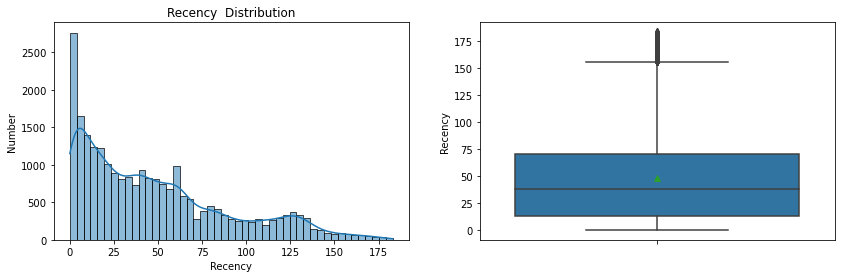

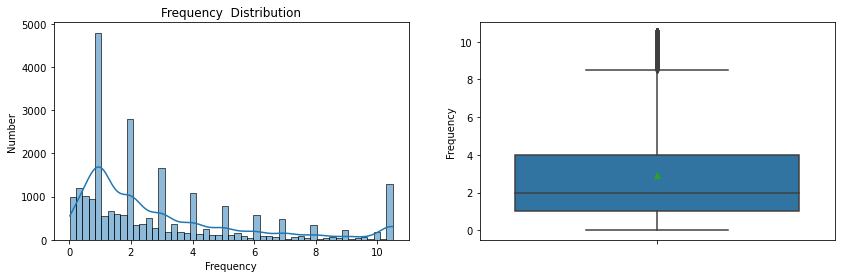

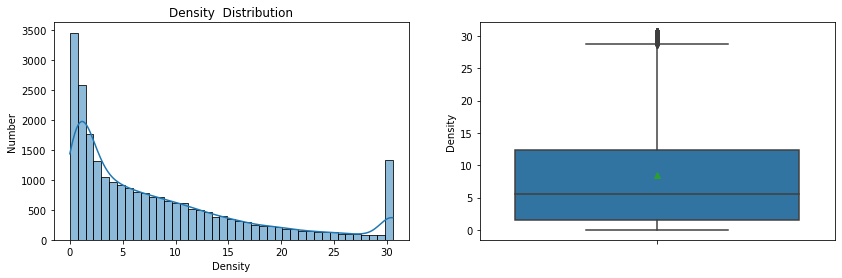

In [232]:
visualize_numerical_lst(free_cluster_df,["Recency","Frequency","Density"])

In [235]:
free_cluster_df[["Recency","Frequency","Density"]].describe(percentiles = [.2,.4,.6,.8])

,Recency,Frequency,Density
count,24820.000000,24820.000000,24820.000000
mean,47.762248,2.932826,8.424927
std,41.860943,2.787742,8.547486
min,0.000000,0.016529,0.000000
20%,9.000000,1.000000,1.107265
40%,26.000000,1.352305,3.550000
50%,38.000000,2.000000,5.506039
60%,49.000000,2.500000,7.900000
80%,82.000000,5.000000,14.566667
max,183.000000,10.500000,30.550000


### 1. Recency

#### 1. Determine K for Recency

In [236]:
def plot_sse(sse):
#     sse = find_sse(df.loc[:,[col]], max_k = 10) 
    plt.figure()
    plt.plot(list(sse.keys()),list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.show() 

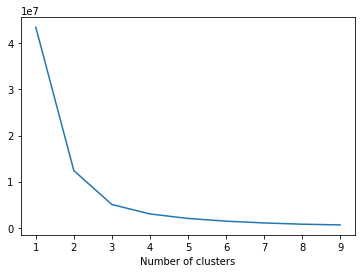

In [237]:
## Elbow Method to determine K
sse = find_sse(free_cluster_df.loc[:,['Recency']], max_k = 10) 
plot_sse(sse)
# k_optimal  = 3

#### 2. Recency Clustering

In [238]:
# ## RecencyCluster_k = 3
k_clus = 3
free_cluster_df = run_kmean_clustering(free_cluster_df,["Recency"],k_cluster=k_clus)

## Sắp theo thứ tự R càng thấp thì Cluster càng cao
free_cluster_df = order_cluster('RecencyCluster', 'Recency',free_cluster_df,False)
free_cluster_df.groupby("RecencyCluster")['Recency'].describe()

# ## see details of each cluster - Recency

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,4225.0,122.657751,20.476284,91.0,107.0,122.0,134.0,183.0
1,8759.0,57.868364,14.905592,36.0,45.0,56.0,68.0,90.0
2,11836.0,13.548581,10.582826,0.0,4.0,12.0,22.0,35.0


In [ ]:
# #### 4.Summary: Recency chia làm 4 nhóm: Lần cuối cùng cách khoảng
# 1. Nhóm 0: 'hibernate':  > 4.5 tháng // (3.5 tháng - 183) 
# 2. Nhóm 1: 'sleep': khoảng 3 tháng //  (2 tháng - 3.5 tháng)
# 3. Nhóm 2: 'active': khoảng 1.5 tháng // (1 tháng - 2 tháng)
# 4. Nhóm 2: 'very active': khoảng 10 ngày// (0 - 1 tháng)

#### 4.Summary: Recency chia làm 3 nhóm: Lần cuối cùng cách khoảng
1. Nhóm 0: 'hibernate':  > 4tháng // (3 tháng - 6 tháng) 
2. Nhóm 1: 'sleep': khoảng 2tháng //  (1 tháng - 3 tháng)
3. Nhóm 2: 'active': khoảng 1/2 tháng// (0 - 1 tháng)

In [ ]:
# Chọn Recency_K = 3

### 2 Frequency - số lần nghe trong 1 ngày

#### 1. Determine K for Frequency

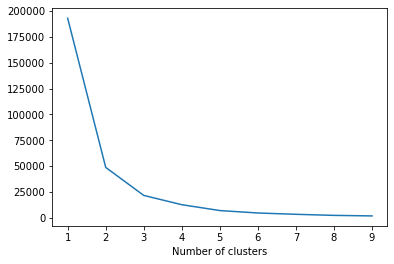

In [239]:
## Elbow Method to determine K

sse = find_sse(free_cluster_df.loc[:,['Frequency']], max_k = 10) 
plot_sse(sse) 

# k_optimal  = 4

#### 3. Frequency Clustering

In [241]:
# ## FrequencyCluster_k = 4
k_clus = 4

free_cluster_df = run_kmean_clustering(free_cluster_df,["Frequency"],k_cluster=k_clus)

## Sắp theo thứ tự R càng thấp thì Cluster càng cao
free_cluster_df = order_cluster('FrequencyCluster', 'Frequency',free_cluster_df,True)
free_cluster_df.groupby("FrequencyCluster")['Frequency'].describe()

# ## see details of each cluster - Frequency

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,11168.0,0.860777,0.409174,0.016529,0.545455,1.000000,1.000000,1.791667
1,8118.0,2.724773,0.733095,1.793103,2.000000,2.625000,3.036706,4.214286
2,3185.0,5.708762,0.922954,4.216216,5.000000,5.583333,6.444444,7.714286
3,2349.0,9.739243,0.983472,7.750000,9.000000,10.500000,10.500000,10.500000


#### 4.Summary: Frequency chia làm 4 nhóm:
1. Nhóm 0: ít dùng : 1 lần/ngày (0 - <2 )
2. Nhóm 1: Dùng mức độ tb: 3 lần/ngày (2 - <4 )
3. Nhóm 2: Dùng mức độ thường xuyên: 6lần/ngày (4 - 8)
4. Nhóm 3: Dùng mức độ thường xuyên: 10lần/ngày (8 - 11)

### 3.Density - Thời lượng cho mỗi lượt nghe (tính bằng phút)

#### 1. Determine K for Density

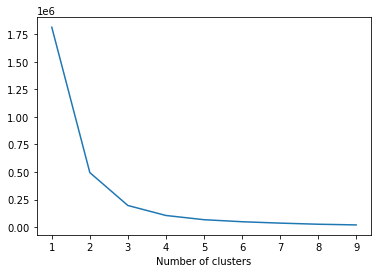

In [242]:
## Elbow Method to determine K

sse = find_sse(free_cluster_df.loc[:,['Density']], max_k = 10) 

plot_sse(sse)

# k_optimal  = 4

#### 3. Density Clustering

In [243]:
# ## DensityCluster_k = 4
k_clus = 4
free_cluster_df = run_kmean_clustering(free_cluster_df,["Density"],k_cluster=k_clus)

## Sắp theo thứ tự R càng thấp thì Cluster càng cao
free_cluster_df = order_cluster('DensityCluster', 'Density',free_cluster_df,True)
free_cluster_df.groupby("DensityCluster")['Density'].describe()

# ## see details of each cluster - Frequency

,count,mean,std,min,25%,50%,75%,max
DensityCluster,,,,,,,,
0,11797.0,1.817569,1.400454,0.000000,0.630931,1.411111,2.800000,5.037500
1,6689.0,8.297435,2.054753,5.041176,6.525758,8.160000,10.038571,12.246154
2,3906.0,16.264076,2.800155,12.250000,13.820882,15.816026,18.493922,22.233333
3,2428.0,28.268453,2.873943,22.239655,25.676949,30.550000,30.550000,30.550000


# 4.Summary: Density chia làm 3 nhóm:
1. Nhóm 0: lướt: trung bình khoảng 2' cho mỗi lượt nghe
2. Nhóm 1: mật độ TB: trung bình 8' cho mỗi lượt nghe
3. Nhóm 2: mật độ cao: trung bình 15' (1h) cho mỗi lượt nghe
4. Nhóm 3: mật độ rất cao: trung bình 28' (1h) cho mỗi lượt nghe

### OverallCluster:
1. F: 4
2. D: 4
3. R: 3

In [135]:
free_cluster_df["ClusterCode"] = free_cluster_df["RecencyCluster"].astype("string")+free_cluster_df["FrequencyCluster"].astype("string")+free_cluster_df["DensityCluster"].astype("string")

In [136]:
free_cluster_df["ClusterCode"].value_counts()

200    7316
100    6169
201    3361
000    3058
101    1763
001     888
202     521
210     403
102     330
110     267
211     204
111     151
010     123
002     120
011      81
212      18
112      15
203      11
103      10
003       4
012       4
220       2
113       1
Name: ClusterCode, dtype: Int64

In [139]:
free_cluster_df.to_csv("data/free_cluster_df.csv")
subcribe_cluster_df.to_csv("data/subcribe_cluster_df.csv")

## Output dữ liệu